# Pytorch CNN Architecture
This is a repo from [GitHub](https://github.com/kumar-shridhar/PyTorch-BayesianCNN), for the complete version please clone the repo.

# Module Import

In [1]:
# The programme is originally run in Python 2
# from __future__ import print_function

# Import Official Module
import os
import argparse

import torch
import numpy as np
from torch.optim import Adam, lr_scheduler
from torch.nn import functional as F

import data
import utils
import metrics

# Import Self-defined Module
import config_bayesian as cfg
from models.BayesianModels.Bayesian3Conv3FC import BBB3Conv3FC
from models.BayesianModels.BayesianAlexNet import BBBAlexNet
from models.BayesianModels.BayesianLeNet import BBBLeNet

# CUDA

In [2]:
# CUDA settings
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Bayesian CNN Model Import

In [3]:
def getModel(net_type, inputs, outputs, priors, layer_type, activation_type):
    if (net_type == 'lenet'):
        return BBBLeNet(outputs, inputs, priors, layer_type, activation_type)
    elif (net_type == 'alexnet'):
        return BBBAlexNet(outputs, inputs, priors, layer_type, activation_type)
    elif (net_type == '3conv3fc'):
        return BBB3Conv3FC(outputs, inputs, priors, layer_type, activation_type)
    else:
        raise ValueError('Network should be either [LeNet / AlexNet / 3Conv3FC')

# Function: Model Training

In [4]:
def train_model(net, optimizer, criterion, trainloader, num_ens=1, beta_type=0.1, epoch=None, num_epochs=None):
    net.train()
    training_loss = 0.0
    
    accs = []
    kl_list = []
    for i, (inputs, labels) in enumerate(trainloader, 1):

        optimizer.zero_grad()

        inputs, labels = inputs.to(device), labels.to(device)
        outputs = torch.zeros(inputs.shape[0], net.num_classes, num_ens).to(device)

        kl = 0.0
        for j in range(num_ens):
            net_out, _kl = net(inputs)
            kl += _kl
            outputs[:, :, j] = F.log_softmax(net_out, dim=1)
        
        kl = kl / num_ens
        kl_list.append(kl.item())
        log_outputs = utils.logmeanexp(outputs, dim=2)

        beta = metrics.get_beta(i-1, len(trainloader), beta_type, epoch, num_epochs)
        loss = criterion(log_outputs, labels, kl, beta)
        loss.backward()
        optimizer.step()

        accs.append(metrics.acc(log_outputs.data, labels))
        training_loss += loss.cpu().data.numpy()
    return training_loss/len(trainloader), np.mean(accs), np.mean(kl_list)

# Function: Model Validation

In [5]:
def validate_model(net, criterion, validloader, num_ens=1, beta_type=0.1, epoch=None, num_epochs=None):
    """Calculate ensemble accuracy and NLL Loss"""
    net.train()
    valid_loss = 0.0
    accs = []

    for i, (inputs, labels) in enumerate(validloader):
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = torch.zeros(inputs.shape[0], net.num_classes, num_ens).to(device)
        kl = 0.0
        for j in range(num_ens):
            net_out, _kl = net(inputs)
            kl += _kl
            outputs[:, :, j] = F.log_softmax(net_out, dim=1).data

        log_outputs = utils.logmeanexp(outputs, dim=2)

        beta = metrics.get_beta(i-1, len(validloader), beta_type, epoch, num_epochs)
        valid_loss += criterion(log_outputs, labels, kl, beta).item()
        accs.append(metrics.acc(log_outputs, labels))

    return valid_loss/len(validloader), np.mean(accs)

# Function: Running

In [6]:
def run(dataset, net_type):

    # Hyper Parameter settings
    layer_type = cfg.layer_type
    activation_type = cfg.activation_type
    priors = cfg.priors

    train_ens = cfg.train_ens
    valid_ens = cfg.valid_ens
    n_epochs = cfg.n_epochs
    lr_start = cfg.lr_start
    num_workers = cfg.num_workers
    valid_size = cfg.valid_size
    batch_size = cfg.batch_size
    beta_type = cfg.beta_type

    trainset, testset, inputs, outputs = data.getDataset(dataset)
    train_loader, valid_loader, test_loader = data.getDataloader(
        trainset, testset, valid_size, batch_size, num_workers)
    net = getModel(net_type, inputs, outputs, priors, layer_type, activation_type).to(device)

    ckpt_dir = f'checkpoints/{dataset}/bayesian'
    ckpt_name = f'checkpoints/{dataset}/bayesian/model_{net_type}_{layer_type}_{activation_type}.pt'

    if not os.path.exists(ckpt_dir):
        os.makedirs(ckpt_dir, exist_ok=True)

    criterion = metrics.ELBO(len(trainset)).to(device)
    optimizer = Adam(net.parameters(), lr=lr_start)
    lr_sched = lr_scheduler.ReduceLROnPlateau(optimizer, patience=6, verbose=True)
    valid_loss_max = np.Inf
    for epoch in range(n_epochs):  # loop over the dataset multiple times

        train_loss, train_acc, train_kl = train_model(net, optimizer, criterion, train_loader, num_ens=train_ens, beta_type=beta_type, epoch=epoch, num_epochs=n_epochs)
        valid_loss, valid_acc = validate_model(net, criterion, valid_loader, num_ens=valid_ens, beta_type=beta_type, epoch=epoch, num_epochs=n_epochs)
        lr_sched.step(valid_loss)

        print('Epoch: {} \tTraining Loss: {:.4f} \tTraining Accuracy: {:.4f} \tValidation Loss: {:.4f} \tValidation Accuracy: {:.4f} \ttrain_kl_div: {:.4f}'.format(
            epoch, train_loss, train_acc, valid_loss, valid_acc, train_kl))

        # save model if validation accuracy has increased
        if valid_loss <= valid_loss_max:
            print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
                valid_loss_max, valid_loss))
            torch.save(net.state_dict(), ckpt_name)
            valid_loss_max = valid_loss

# Main

In [11]:
if __name__ == '__main__':
    # parser = argparse.ArgumentParser(description = "PyTorch Bayesian Model Training")
    # parser.add_argument('--net_type', default='lenet', type=str, help='model')
    # parser.add_argument('--dataset', default='MNIST', type=str, help='dataset = [MNIST/CIFAR10/CIFAR100]')
    # args = parser.parse_args()

    # run(args.dataset, args.net_type)
    run(dataset='MNIST', net_type='lenet')

/home/zy/anaconda3/envs/BDL/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


Epoch: 0 	Training Loss: 912586.4122 	Training Accuracy: 0.4253 	Validation Loss: 596386.2513 	Validation Accuracy: 0.8707 	train_kl_div: 8167724.6037
Validation loss decreased (inf --> 596386.251330).  Saving model ...
Epoch: 1 	Training Loss: 500316.7409 	Training Accuracy: 0.8959 	Validation Loss: 424104.3757 	Validation Accuracy: 0.9240 	train_kl_div: 4794008.1037
Validation loss decreased (596386.251330 --> 424104.375665).  Saving model ...
Epoch: 2 	Training Loss: 372923.0404 	Training Accuracy: 0.9285 	Validation Loss: 327732.6011 	Validation Accuracy: 0.9368 	train_kl_div: 3583550.1197
Validation loss decreased (424104.375665 --> 327732.601064).  Saving model ...
Epoch: 3 	Training Loss: 292973.0948 	Training Accuracy: 0.9434 	Validation Loss: 262943.2410 	Validation Accuracy: 0.9422 	train_kl_div: 2815120.6383
Validation loss decreased (327732.601064 --> 262943.241024).  Saving model ...
Epoch: 4 	Training Loss: 236416.3474 	Training Accuracy: 0.9532 	Validation Loss: 213917.0

# Uncertianty Estimation

    epistemic_norm  aleatoric_norm  epistemic_soft  aleatoric_soft  category  \
0     5.806949e-04        0.007793    4.372607e-11    1.958502e-06         0   
1     2.308335e-03        0.062702    8.904768e-09    4.923344e-05         1   
2     1.367513e-04        0.005354    3.510205e-11    2.154358e-06         2   
3     2.720325e-08        0.000041    1.769386e-13    1.215294e-07         3   
4     1.030826e-03        0.024934    5.844674e-09    2.438513e-05         4   
5     4.971867e-07        0.000260    1.069588e-11    6.802483e-07         5   
6     2.512227e-04        0.008262    2.050383e-11    1.703877e-06         6   
7     2.091699e-04        0.008408    8.883347e-12    1.296990e-06         7   
8     2.101044e-04        0.009481    1.049585e-09    1.359265e-05         8   
9     5.458746e-06        0.001877    7.810756e-11    3.255000e-06         9   
10    1.458930e-03        0.062857    1.187105e-03    3.869458e-02         0   
11    4.595472e-03        0.106107    4.

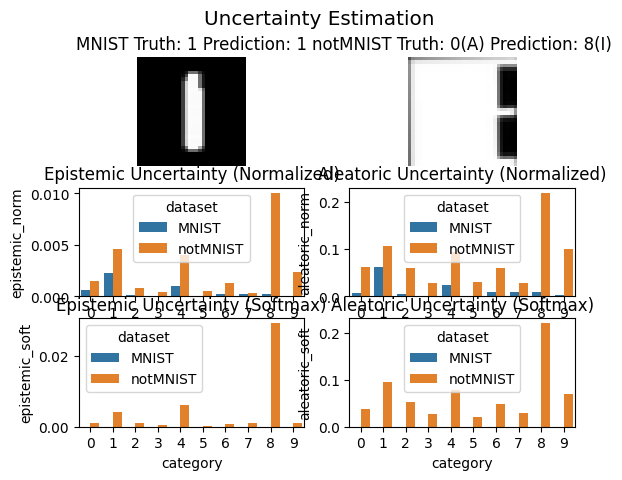

In [2]:
import argparse
import torch
import numpy as np
import pandas as pd
import seaborn as sns
from PIL import Image
import torchvision
from torch.nn import functional as F
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

import data
from main_bayesian import getModel
import config_bayesian as cfg


# CUDA settings
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

mnist_set = None
notmnist_set = None

transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((32, 32)),
    transforms.ToTensor(),
    ])


def init_dataset(notmnist_dir):
    global mnist_set
    global notmnist_set
    mnist_set, _, _, _ = data.getDataset('MNIST')
    notmnist_set = torchvision.datasets.ImageFolder(root=notmnist_dir)


def get_uncertainty_per_image(model, input_image, T=15, normalized=False):
    input_image = input_image.unsqueeze(0)
    input_images = input_image.repeat(T, 1, 1, 1)

    net_out, _ = model(input_images)
    pred = torch.mean(net_out, dim=0).cpu().detach().numpy()
    if normalized:
        prediction = F.softplus(net_out)
        p_hat = prediction / torch.sum(prediction, dim=1).unsqueeze(1)
    else:
        p_hat = F.softmax(net_out, dim=1)
    p_hat = p_hat.detach().cpu().numpy()
    p_bar = np.mean(p_hat, axis=0)

    temp = p_hat - np.expand_dims(p_bar, 0)
    epistemic = np.dot(temp.T, temp) / T
    epistemic = np.diag(epistemic)

    aleatoric = np.diag(p_bar) - (np.dot(p_hat.T, p_hat) / T)
    aleatoric = np.diag(aleatoric)

    return pred, epistemic, aleatoric


def get_uncertainty_per_batch(model, batch, T=15, normalized=False):
    batch_predictions = []
    net_outs = []
    batches = batch.unsqueeze(0).repeat(T, 1, 1, 1, 1)

    preds = []
    epistemics = []
    aleatorics = []
    
    for i in range(T):  # for T batches
        net_out, _ = model(batches[i].cuda())
        net_outs.append(net_out)
        if normalized:
            prediction = F.softplus(net_out)
            prediction = prediction / torch.sum(prediction, dim=1).unsqueeze(1)
        else:
            prediction = F.softmax(net_out, dim=1)
        batch_predictions.append(prediction)
    
    for sample in range(batch.shape[0]):
        # for each sample in a batch
        pred = torch.cat([a_batch[sample].unsqueeze(0) for a_batch in net_outs], dim=0)
        pred = torch.mean(pred, dim=0)
        preds.append(pred)

        p_hat = torch.cat([a_batch[sample].unsqueeze(0) for a_batch in batch_predictions], dim=0).detach().cpu().numpy()
        p_bar = np.mean(p_hat, axis=0)

        temp = p_hat - np.expand_dims(p_bar, 0)
        epistemic = np.dot(temp.T, temp) / T
        epistemic = np.diag(epistemic)
        epistemics.append(epistemic)

        aleatoric = np.diag(p_bar) - (np.dot(p_hat.T, p_hat) / T)
        aleatoric = np.diag(aleatoric)
        aleatorics.append(aleatoric)

    epistemic = np.vstack(epistemics)  # (batch_size, categories)
    aleatoric = np.vstack(aleatorics)  # (batch_size, categories)
    preds = torch.cat([i.unsqueeze(0) for i in preds]).cpu().detach().numpy()  # (batch_size, categories)

    return preds, epistemic, aleatoric


def get_sample(dataset, sample_type='mnist'):
    idx = np.random.randint(len(dataset.targets))
    if sample_type=='mnist':
        sample = dataset.data[idx]
        truth = dataset.targets[idx]
    else:
        path, truth = dataset.samples[idx]
        sample = torch.from_numpy(np.array(Image.open(path)))

    sample = sample.unsqueeze(0)
    sample = transform(sample)
    return sample.to(device), truth


def run(net_type, weight_path, notmnist_dir):
    init_dataset(notmnist_dir)

    layer_type = cfg.layer_type
    activation_type = cfg.activation_type

    net = getModel(net_type, 1, 10, priors=None, layer_type=layer_type, activation_type=activation_type)
    net.load_state_dict(torch.load(weight_path))
    net.train()
    net.to(device)

    fig = plt.figure()
    fig.suptitle('Uncertainty Estimation', fontsize='x-large')
    mnist_img = fig.add_subplot(321)
    notmnist_img = fig.add_subplot(322)
    epi_stats_norm = fig.add_subplot(323)
    ale_stats_norm = fig.add_subplot(324)
    epi_stats_soft = fig.add_subplot(325)
    ale_stats_soft = fig.add_subplot(326)

    sample_mnist, truth_mnist = get_sample(mnist_set)
    pred_mnist, epi_mnist_norm, ale_mnist_norm = get_uncertainty_per_image(net, sample_mnist, T=25, normalized=True)
    pred_mnist, epi_mnist_soft, ale_mnist_soft = get_uncertainty_per_image(net, sample_mnist, T=25, normalized=False)
    mnist_img.imshow(sample_mnist.squeeze().cpu(), cmap='gray')
    mnist_img.axis('off')
    mnist_img.set_title('MNIST Truth: {} Prediction: {}'.format(int(truth_mnist), int(np.argmax(pred_mnist))))

    sample_notmnist, truth_notmnist = get_sample(notmnist_set, sample_type='notmnist')
    pred_notmnist, epi_notmnist_norm, ale_notmnist_norm = get_uncertainty_per_image(net, sample_notmnist, T=25, normalized=True)
    pred_notmnist, epi_notmnist_soft, ale_notmnist_soft = get_uncertainty_per_image(net, sample_notmnist, T=25, normalized=False)
    notmnist_img.imshow(sample_notmnist.squeeze().cpu(), cmap='gray')
    notmnist_img.axis('off')
    notmnist_img.set_title('notMNIST Truth: {}({}) Prediction: {}({})'.format(
        int(truth_notmnist), chr(65 + truth_notmnist), int(np.argmax(pred_notmnist)), chr(65 + np.argmax(pred_notmnist))))

    x = list(range(10))
    data = pd.DataFrame({
        'epistemic_norm': np.hstack([epi_mnist_norm, epi_notmnist_norm]),
        'aleatoric_norm': np.hstack([ale_mnist_norm, ale_notmnist_norm]),
        'epistemic_soft': np.hstack([epi_mnist_soft, epi_notmnist_soft]),
        'aleatoric_soft': np.hstack([ale_mnist_soft, ale_notmnist_soft]),
        'category': np.hstack([x, x]),
        'dataset': np.hstack([['MNIST']*10, ['notMNIST']*10])
    })
    print(data)
    sns.barplot(x='category', y='epistemic_norm', hue='dataset', data=data, ax=epi_stats_norm)
    sns.barplot(x='category', y='aleatoric_norm', hue='dataset', data=data, ax=ale_stats_norm)
    epi_stats_norm.set_title('Epistemic Uncertainty (Normalized)')
    ale_stats_norm.set_title('Aleatoric Uncertainty (Normalized)')

    sns.barplot(x='category', y='epistemic_soft', hue='dataset', data=data, ax=epi_stats_soft)
    sns.barplot(x='category', y='aleatoric_soft', hue='dataset', data=data, ax=ale_stats_soft)
    epi_stats_soft.set_title('Epistemic Uncertainty (Softmax)')
    ale_stats_soft.set_title('Aleatoric Uncertainty (Softmax)')

    plt.show()


if __name__ == '__main__':
    # parser = argparse.ArgumentParser(description = "PyTorch Uncertainty Estimation b/w MNIST and notMNIST")
    # parser.add_argument('--net_type', default='lenet', type=str, help='model')
    # parser.add_argument('--weights_path', default='checkpoints/MNIST/bayesian/model_lenet_lrt_softplus.pt', type=str, help='weights for model')
    # parser.add_argument('--notmnist_dir', default='data/notMNIST_small/', type=str, help='weights for model')
    # args = parser.parse_args()

    run('lenet', 'checkpoints/MNIST/bayesian/model_lenet_lrt_softplus.pt', 'data/notMNIST_small/')
